In [26]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as pyplt
import matplotlib.pylab as plt

In [2]:
#BASEDIR = '/Users/frederik/Google Drive/University/UC3M/bi_semester_4/smart_society'
BASEDIR = '/Users/admin/Documents/BIMESTRE_4_MASTER/analytics_for_smart_society'
DATA_DIR = 'data/asg_two'
DATA_FILE = 'HAR_database.mat'
META_DATA = 'database_description.txt'
COLNAMES = ['acc_z', 'acc_xy', 'gyro_z','gyro_x','gyro_z','label']#no lo he cambiado pero el data del gyroscope no tiene bien los nombres ['acc_z', 'acc_xy', 'gyro_x','gyro_y','gyro_z','label']

In [3]:
def preprocessing():
    data = loadmat(os.path.join(BASEDIR,DATA_DIR, DATA_FILE))
    train_data = data['database_training']
    dataframes = []
    for _ in range(train_data.shape[0]):
        temp = np.vstack((train_data[_][0],train_data[_][1]))
        ids  = [_ for meassurement in range(temp.shape[1])]
        temp = np.vstack((temp, ids))
        temp = np.transpose(temp)
        temp = pd.DataFrame((temp),columns=COLNAMES)
        dataframes.append(temp)
    return pd.concat(dataframes)

In [ ]:
train = preprocessing()

In [112]:
train.to_csv(os.path.join(BASEDIR,DATA_DIR,'HAR_database_train.csv'), index=False)

In [6]:
tr=pd.read_csv(os.path.join(BASEDIR,DATA_DIR,'HAR_database_train.csv'))

In [7]:
tr

,acc_z,acc_xy,gyro_z,gyro_x,gyro_z.1,label,user_id
0,0.024173,0.594417,-0.022736,0.111962,0.060499,3.0,0.0
1,0.019905,0.602472,-0.012875,0.103796,0.055157,3.0,0.0
2,0.034749,0.525821,-0.020016,0.103193,0.057541,3.0,0.0
3,0.059832,0.621057,-0.026841,0.104378,0.063853,3.0,0.0
4,0.044743,0.653001,-0.014540,0.103560,0.066084,3.0,0.0
...,...,...,...,...,...,...,...
141421,0.577717,1.784139,-0.081926,-0.095167,0.068769,3.0,7.0
141422,0.577288,1.860482,-0.080316,-0.088788,0.071567,3.0,7.0
141423,0.583964,1.844136,-0.073664,-0.101740,0.081287,3.0,7.0
141424,0.572480,1.783769,-0.073399,-0.089936,0.052906,3.0,7.0


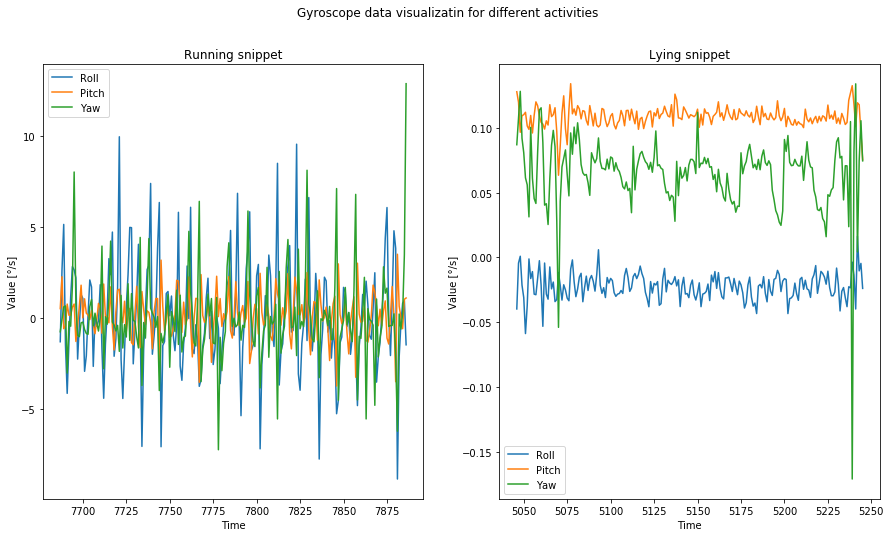

In [140]:

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,8))
fig.suptitle('Gyroscope data visualizatin for different activities')
ax1.plot(tr.query('label==1')[['gyro_z','gyro_x','gyro_z.1']].iloc[0:200])
ax1.set_title('Running snippet')
ax1.set_xlabel('Time')
ax1.set_ylabel('Value [°/s]')
ax1.legend(['Roll','Pitch','Yaw'], loc=0)

ax2.plot(tr.query('label==5')[['gyro_z','gyro_x','gyro_z.1']].iloc[0:200])
ax2.set_title('Lying snippet')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value [°/s]')
ax2.legend(['Roll','Pitch','Yaw'], loc=0)




Regarding data corresponding the lying label, the three axis lie in different ranges, yaw is the axis perpendicular to the transverse plane of the subject as it has the widest range of rotation in the graph in the smallest amount of time (it is the easiest body-rotation when we are lied down), it can be confirmed by looking at the origin of the data, it corresponds to the z axis (mid-body axis). The other two axis cannot be identified just from the graph, but it is known from the information provided with the dataset that the first set of values corresponds to the x-axis. So, it represents movement in the coronal plane of the subject whereas the data in orange would show movement in the sagital plane.

Data is already preprocessed. The following scheme is followed:
- Segmentation
- Feature Extraction
- Dimensionality Reduction
- Classification and Recognition

Lo he copiado de aqui https://github.com/NickFoubert/simple-segment/blob/master/wrappers.py

In [142]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
def draw_plot(data,plot_title):
    plot(range(len(data)),data,alpha=0.8,color='red')
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)


In [175]:
def slidingwindowsegment(sequence, create_segment, compute_error, max_error, seq_range=None):
    """
    Return a list of line segments that approximate the sequence.
    The list is computed using the sliding window technique. 
    Parameters
    ----------
    sequence : sequence to segment
    create_segment : a function of two arguments (sequence, sequence range) that returns a line segment that approximates the sequence data in the specified range
    compute_error: a function of two argments (sequence, segment) that returns the error from fitting the specified line segment to the sequence data
    max_error: the maximum allowable line segment fitting error
    """
    if not seq_range:
        seq_range = (0,len(sequence)-1)

    start = seq_range[0]
    end = start
    result_segment = create_segment(sequence,(seq_range[0],seq_range[1]))
    while end < seq_range[1]:
        end += 1
        test_segment = create_segment(sequence,(start,end))
        error = compute_error(sequence,test_segment)
        if error <= max_error:
            result_segment = test_segment
        else:
            break

    if end == seq_range[1]:
        return [result_segment]
    else:
        return [result_segment] + slidingwindowsegment(sequence, create_segment, compute_error, max_error, (end-1,seq_range[1]))
        

In [36]:
def regression(sequence, seq_range):
    """Return (x0,y0,x1,y1) of a line fit to a segment of a sequence using linear regression"""
    p, error = leastsquareslinefit(sequence,seq_range)
    y0 = p[0]*seq_range[0] + p[1]
    y1 = p[0]*seq_range[1] + p[1]
    return (seq_range[0],y0,seq_range[1],y1)
    

In [37]:
def sumsquared_error(sequence, segment):
    """Return the sum of squared errors for a least squares line fit of one segment of a sequence"""
    x0,y0,x1,y1 = segment
    p, error = leastsquareslinefit(sequence,(x0,x1))
    return error

In [172]:
max_error = 0.05

In [40]:
from numpy import arange, array, ones
from numpy.linalg import lstsq

def leastsquareslinefit(sequence,seq_range):
    """Return the parameters and error for a least squares line fit of one segment of a sequence"""
    x = arange(seq_range[0],seq_range[1]+1)
    y = array(sequence[seq_range[0]:seq_range[1]+1])
    A = ones((len(x),2),float)
    A[:,0] = x
    (p,residuals,rank,s) = lstsq(A,y)
    try:
        error = residuals[0]
    except IndexError:
        error = 0.0
    return (p,error)

<ipython-input-40-dd5bfadc02f2>:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = lstsq(A,y)


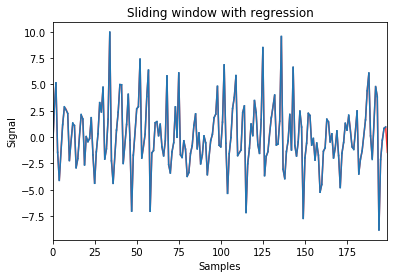

In [176]:

figure()
segments = slidingwindowsegment(tr.query('label==1')[['gyro_z']][0:200], regression, sumsquared_error, max_error)


draw_plot(tr.query('label==1')[['gyro_z']][0:200],"Sliding window with regression")
draw_segments(segments)


In [177]:
len(segments)#de 200 a 182 es poco

182

In [163]:
def bottomupsegment(sequence, create_segment, compute_error, max_error):
    """
    Return a list of line segments that approximate the sequence.
    
    The list is computed using the bottom-up technique.
    
    Parameters
    ----------
    sequence : sequence to segment
    create_segment : a function of two arguments (sequence, sequence range) that returns a line segment that approximates the sequence data in the specified range
    compute_error: a function of two argments (sequence, segment) that returns the error from fitting the specified line segment to the sequence data
    max_error: the maximum allowable line segment fitting error
    
    """
    segments = [create_segment(sequence,seq_range) for seq_range in zip(range(len(sequence))[:-1],range(len(sequence))[1:])]
    mergesegments = [create_segment(sequence,(seg1[0],seg2[2])) for seg1,seg2 in zip(segments[:-1],segments[1:])]
    mergecosts = [compute_error(sequence,segment) for segment in mergesegments]

    while min(mergecosts) < max_error:
        idx = mergecosts.index(min(mergecosts))
        segments[idx] = mergesegments[idx]
        del segments[idx+1]

        if idx > 0:
            mergesegments[idx-1] = create_segment(sequence,(segments[idx-1][0],segments[idx][2]))
            mergecosts[idx-1] = compute_error(sequence,mergesegments[idx-1])

        if idx+1 < len(mergecosts):
            mergesegments[idx+1] = create_segment(sequence,(segments[idx][0],segments[idx+1][2]))
            mergecosts[idx+1] = compute_error(sequence,mergesegments[idx])

        del mergesegments[idx]
        del mergecosts[idx]

    return segments

<ipython-input-40-dd5bfadc02f2>:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = lstsq(A,y)


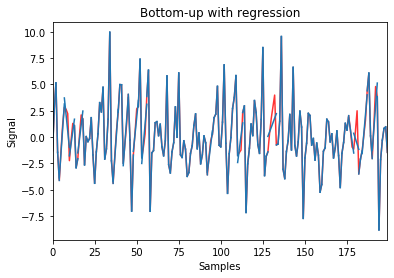

In [173]:
#bottom-up with regression
figure()
segments = bottomupsegment(tr.query('label==1')[['gyro_z']][0:200], regression, sumsquared_error, max_error)
draw_plot(tr.query('label==1')[['gyro_z']][0:200],"Bottom-up with regression")
draw_segments(segments)

In [174]:
len(segments)

167

Mejor bottomup (como dice el paper el sliding window es flojo) porque tengo que subir mucho el maxerror. Si no hay más approaches en el link
He cogido solo 200 y solo una vble para probar